# Handle Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None

C:\Users\isabe\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score, f1_score, precision_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer # sklearn tries to find the row that matches most with the other features in the row with missing value
from sklearn.experimental import enable_iterative_imputer #sklearn trains a regression model using the other features to predict them missing value
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

# Load dataset

In [3]:
def load() -> pd.DataFrame:
    df = pd.read_pickle("new_data.pickle")

    outsample = df[df["Date Announced"] > "2020-01-01"] # true out of sample, do not touch
    insample = df[df["Date Announced"] <= "2020-01-01"]

    return outsample, insample 

_, df = load()

In [4]:
df.head()

,Success,Date Announced,Date Effective,Date Withdrawn,Deal Number,Target Name,Target Primary Ticker Symbol,Target Industry Sector,Acquiror Name,Acquiror Primary Ticker Symbol,Acquiror Industry Sector,Exchange Ratio,Price Per Share,Acquiror's price per share,Acquiror Closing Price 1 Day After Ann Date ($),Acquiror Closing Price 60 Days After Ann Date ($),Acquiror Closing Price 90 Days After Ann Date ($),Acquiror Closing Price 180 Days After Ann Date ($),Target Share Price 1 Day Prior to Announcement ($),Target Closing Price 1 Day After Ann Date ($),Target Closing Price 60 Days After Ann Date ($),Target Closing Price 90 Days After Ann Date ($),Target Closing Price 180 Days After Ann Date ($),Premium 1 day prior to announce- ment date,Premium 1 week prior to announce- ment date,Premium 4 weeks prior to ann. date,S&P 500 Closing Price 1 Day Before Announcement,Poison Pill,% sought,Ratio of Offer Price to EPS,Ratio of Deal Value to Sales,Ratio of Deal Value to EBIT,Ratio of Deal Value to EBITDA,Ratio of Deal Value to Net Income,Ratio of Enterprise Value to Sales,Ratio of Enterprise Value to EBIT,Ratio of Enterprise Value to EBITDA,Ratio of Enterprise Value to Net Income,Equity Value/ Net Sales,Ratio of Equity Value to EBIT,Ratio of Equity Value at Announcement to EBITDA,Ratio of Equity Value to Net Income,Target Ebit 3-Year Growth Rate (%),Target Ebit 5-Year Growth Rate (%),EBIT Margin,Target EBITDA Three Year Growth Rate,Target EBITDA Five Year Growth Rate,EBITDA Margin,Target Net Assets Three Year Growth Rate,Target Net Assets Five Year Growth Rate,Target Net Sales 5-Year Growth Rate (%),Total Fee %,Target Fee %,Target Total Assets 5-Year Growth Rate (%),Target Total Lia. 5-Year Growth Rate (%),Common Equity Multiple,Value / Net Assets,EBIT / Return on Assets,EBITDA ROA,Enterprise Value / Net Assets,Enterprise Value / Pre-tax Inc,Enterprise Value / Tangible Book Value,Ratio of Offer Price to Book Value,Target Net Sales LTM ($mil),EBIT Last Twelve Months ($ Mil),Pre-tax Income Last Twelve Months ($ Mil),Net Income Last Twelve Months ($ Mil),Target Net Assets ($mil),Target Total Assets ($mil),Target EBITDA LTM ($mil),Target Book Value Per Share LTM (US$),Target Common Equity ($mil),Target Earnings Per Share LTM (US$),Value Based on Effective Date ($mil),Value Common at Eff. Date ($mil),Equity Value at Effective Date ($mil),Target Book Value/sh One Year Prior,Target Book Value/sh Two Years Prior,Target Book Value/sh Three Years Prior,Target Capital Expend. One Year Prior ($ mil),Target Capital Expend. Two Years Prior ($ mil),Target Capital Expend. Three Years Prior ($ mil),Target Cash & Mktbl. Securities One Year Prior ($ mil),Target Cash & Mktbl. Securities Two Years Prior ($ mil),Target Cash & Mktbl. Securities Three Years Prior ($ mil),Host Curr. Target Long Term Debt One Year Prior (mil),Host Curr. Target Long Term Debt Two Years Prior (mil),Host Curr. Target Long Term Debt Three Years Prior (mil),Target Long- Term Liab. 1-Year Prior ($ mil),Target Long- Term Liab. 2-Years Prior ($ mil),Target Long- Term Liab. 3-Years Prior ($ mil),Target Net Cash Fr. Investing One Year Prior,Target Net Cash Fr. Investing Two Years Prior,Target Net Cash Fr. Investing Three Years Prior,Target Net Cash fr. Financing One Year Prior,Target Net Cash fr. Financing Two Years Prior,Target Net Cash fr. Financing Three Years Prior,Target Straight Debt One Year Prior ($ mil),Target Straight Debt Two Years Prior ($ mil),Target Straight Debt Three Years Prior ($ mil)
3,0,2012-01-13,NaT,2012-05-04,2379612020,Georgia Gulf Corp,GGC,Chemicals and Allied Products,Westlake Chemical Corp,WLK,Chemicals and Allied Products,NaN,35.00,NaN,56.340,65.690,61.120,54.010,24.48,33.48,33.07,32.06,27.23,42.97,62.94,89.39,1295.50,Yes,95.2,21.0,0.372,8.9,5.067,21.199,0.533,12.718,7.260,30.376,0.372,8.877,5.067,21.200,118.999,-7.857,0.042,27.36,-8.503,0.073,13.90,25.53,0.52,NaN,NaN,-7.09,-12.94,2.453,2.5,0.082,0.144,3.515,32.078,7.521,2.452,3222.884,135.038,53.5,56.5,488.7,1640.4

# EDA

Summary
- Drop columns that user may not be able to provide without knowing the outcome of the merger (e.g. Value Based on Effective Date ($mil)) or metrics measured at 180 days as on average, merger results can be earlier
- The data is positively skewed. This would affect our choice of loss function, e.g. using focal loss instead of binary cross entropy and our choice of metrics. It would also affect our choice of performance metrics, for e.g. choosing AUC score from ROC curve. We can also try to apply synthetic data creation methods, such as SMOTE, GAN or VAEs
- Year should be dropped as the model is used to predict future announcements. Month was found to be independent to success of merger.
- There are industries with low merger count that have 100% success rate. These rows could be dropped.
- Relating to time series data, there is a difference between the percentage change throughout different time periods for merger success and merger failed cases so we could keep these columns
- Drop columns with more than 50% NA

Functions for EDA

In [5]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2

def add_labels_inside_chart(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')

def add_labels_centered(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
        
def conductChiSquaredTest(table):
    print("Checking independence by Chi Squared Test: ")
    stat, p, dof, expected = chi2_contingency(table)
    alpha = 0.05
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

In [6]:
cleaned_df = df.copy()

There are 100 columns. The high dimensionality signals for a need for dimensionality reduction.

In [7]:
df.shape

(1196, 100)

In [8]:
success_df = df[df["Success"]==1]
failure_df = df[df["Success"]==0]

In [9]:
success_df.describe()

,Success,Deal Number,Exchange Ratio,Price Per Share,Acquiror's price per share,Acquiror Closing Price 1 Day After Ann Date ($),Acquiror Closing Price 60 Days After Ann Date ($),Acquiror Closing Price 90 Days After Ann Date ($),Acquiror Closing Price 180 Days After Ann Date ($),Target Share Price 1 Day Prior to Announcement ($),Target Closing Price 1 Day After Ann Date ($),Target Closing Price 60 Days After Ann Date ($),Target Closing Price 90 Days After Ann Date ($),Target Closing Price 180 Days After Ann Date ($),Premium 1 day prior to announce- ment date,Premium 1 week prior to announce- ment date,Premium 4 weeks prior to ann. date,S&P 500 Closing Price 1 Day Before Announcement,% sought,Ratio of Offer Price to EPS,Ratio of Deal Value to Sales,Ratio of Deal Value to EBIT,Ratio of Deal Value to EBITDA,Ratio of Deal Value to Net Income,Ratio of Enterprise Value to Sales,Ratio of Enterprise Value to EBIT,Ratio of Enterprise Value to EBITDA,Ratio of Enterprise Value to Net Income,Equity Value/ Net Sales,Ratio of Equity Value to EBIT,Ratio of Equity Value at Announcement to EBITDA,Ratio of Equity Value to Net Income,Target Ebit 3-Year Growth Rate (%),Target Ebit 5-Year Growth Rate (%),EBIT Margin,Target EBITDA Three Year Growth Rate,Target EBITDA Five Year Growth Rate,EBITDA Margin,Target Net Assets Three Year Growth Rate,Target Net Assets Five Year Growth Rate,Target Net Sales 5-Year Growth Rate (%),Total Fee %,Target Fee %,Target Total Assets 5-Year Growth Rate (%),Target Total Lia. 5-Year Growth Rate (%),Common Equity Multiple,Value / Net Assets,EBIT / Return on Assets,EBITDA ROA,Enterprise Value / Net Assets,Enterprise Value / Pre-tax Inc,Enterprise Value / Tangible Book Value,Ratio of Offer Price to Book Value,Target Net Sales LTM ($mil),EBIT Last Twelve Months ($ Mil),Pre-tax Income Last Twelve Months ($ Mil),Net Income Last Twelve Months ($ Mil),Target Net Assets ($mil),Target Total Assets ($mil),Target EBITDA LTM ($mil),Target Book Value Per Share LTM (US$),Target Common Equity ($mil),Target Earnings Per Share LTM (US$),Value Based on Effective Date ($mil),Value Common at Eff. Date ($mil),Equity Value at Effective Date ($mil),Target Book Value/sh One Year Prior,Target Book Value/sh Two Years Prior,Target Book Value/sh Three Years Prior,Target Capital Expend. One Year Prior ($ mil),Target Capital Expend. Two Years Prior ($ mil),Target Capital Expend. Three Years Prior ($ mil),Target Cash & Mktbl. Securities One Year Prior ($ mil),Target Cash & Mktbl. Securities Two Years Prior ($ mil),Target Cash & Mktbl. Securities Three Years Prior ($ mil),Host Curr. Target Long Term Debt One Year Prior (mil),Host Curr. Target Long Term Debt Two Years Prior (mil),Host Curr. Target Long Term Debt Three Years Prior (mil),Target Long- Term Liab. 1-Year Prior ($ mil),Target Long- Term Liab. 2-Years Prior ($ mil),Target Long- Term Liab. 3-Years Prior ($ mil),Target Net Cash Fr. Investing One Year Prior,Target Net Cash Fr. Investing Two Years Prior,Target Net Cash Fr. Investing Three Years Prior,Target Net Cash fr. Financing One Year Prior,Target Net Cash fr. Financing Two Years Prior,Target Net Cash fr. Financing Three Years Prior,Target Straight Debt One Year Prior ($ mil),Target Straight Debt Two Years Prior ($ mil),Target Straight Debt Three Years Prior ($ mil)
count,1054.0,1.054000e+03,427.000000,1054.000000,428.000000,749.000000,746.000000,746.000000,744.000000,1051.000000,1050.000000,952.000000,823.000000,405.000000,1036.000000,1033.000000,1036.000000,1054.000000,1052.000000,925.000000,1053.000000,1031.000000,1026.000000,929.000000,1053.000000,1031.000000,1026.000000,929.000000,1054.000000,1032.000000,1027.000000,930.000000,898.000000,832.000000,1032.000000,892.000000,817.000000,1027.000000,1003.000000,954.000000,1015.000000,900.000000,892.000000,1013.000000,1005.000000,1019.000000,1022.000000,1031.000000,1027.000000,1022.000000,928.000000,824.000000,1020.00000,1054.000000,1051.000000,1054.000000,1054.000000,1053.000000,1054.000000,1029

In [10]:
failure_df.describe()

,Success,Deal Number,Exchange Ratio,Price Per Share,Acquiror's price per share,Acquiror Closing Price 1 Day After Ann Date ($),Acquiror Closing Price 60 Days After Ann Date ($),Acquiror Closing Price 90 Days After Ann Date ($),Acquiror Closing Price 180 Days After Ann Date ($),Target Share Price 1 Day Prior to Announcement ($),Target Closing Price 1 Day After Ann Date ($),Target Closing Price 60 Days After Ann Date ($),Target Closing Price 90 Days After Ann Date ($),Target Closing Price 180 Days After Ann Date ($),Premium 1 day prior to announce- ment date,Premium 1 week prior to announce- ment date,Premium 4 weeks prior to ann. date,S&P 500 Closing Price 1 Day Before Announcement,% sought,Ratio of Offer Price to EPS,Ratio of Deal Value to Sales,Ratio of Deal Value to EBIT,Ratio of Deal Value to EBITDA,Ratio of Deal Value to Net Income,Ratio of Enterprise Value to Sales,Ratio of Enterprise Value to EBIT,Ratio of Enterprise Value to EBITDA,Ratio of Enterprise Value to Net Income,Equity Value/ Net Sales,Ratio of Equity Value to EBIT,Ratio of Equity Value at Announcement to EBITDA,Ratio of Equity Value to Net Income,Target Ebit 3-Year Growth Rate (%),Target Ebit 5-Year Growth Rate (%),EBIT Margin,Target EBITDA Three Year Growth Rate,Target EBITDA Five Year Growth Rate,EBITDA Margin,Target Net Assets Three Year Growth Rate,Target Net Assets Five Year Growth Rate,Target Net Sales 5-Year Growth Rate (%),Total Fee %,Target Fee %,Target Total Assets 5-Year Growth Rate (%),Target Total Lia. 5-Year Growth Rate (%),Common Equity Multiple,Value / Net Assets,EBIT / Return on Assets,EBITDA ROA,Enterprise Value / Net Assets,Enterprise Value / Pre-tax Inc,Enterprise Value / Tangible Book Value,Ratio of Offer Price to Book Value,Target Net Sales LTM ($mil),EBIT Last Twelve Months ($ Mil),Pre-tax Income Last Twelve Months ($ Mil),Net Income Last Twelve Months ($ Mil),Target Net Assets ($mil),Target Total Assets ($mil),Target EBITDA LTM ($mil),Target Book Value Per Share LTM (US$),Target Common Equity ($mil),Target Earnings Per Share LTM (US$),Value Based on Effective Date ($mil),Value Common at Eff. Date ($mil),Equity Value at Effective Date ($mil),Target Book Value/sh One Year Prior,Target Book Value/sh Two Years Prior,Target Book Value/sh Three Years Prior,Target Capital Expend. One Year Prior ($ mil),Target Capital Expend. Two Years Prior ($ mil),Target Capital Expend. Three Years Prior ($ mil),Target Cash & Mktbl. Securities One Year Prior ($ mil),Target Cash & Mktbl. Securities Two Years Prior ($ mil),Target Cash & Mktbl. Securities Three Years Prior ($ mil),Host Curr. Target Long Term Debt One Year Prior (mil),Host Curr. Target Long Term Debt Two Years Prior (mil),Host Curr. Target Long Term Debt Three Years Prior (mil),Target Long- Term Liab. 1-Year Prior ($ mil),Target Long- Term Liab. 2-Years Prior ($ mil),Target Long- Term Liab. 3-Years Prior ($ mil),Target Net Cash Fr. Investing One Year Prior,Target Net Cash Fr. Investing Two Years Prior,Target Net Cash Fr. Investing Three Years Prior,Target Net Cash fr. Financing One Year Prior,Target Net Cash fr. Financing Two Years Prior,Target Net Cash fr. Financing Three Years Prior,Target Straight Debt One Year Prior ($ mil),Target Straight Debt Two Years Prior ($ mil),Target Straight Debt Three Years Prior ($ mil)
count,142.0,1.420000e+02,48.000000,142.000000,49.000000,94.000000,94.000000,94.000000,94.000000,141.000000,142.000000,140.000000,135.000000,127.000000,140.000000,140.000000,140.000000,142.000000,142.000000,124.000000,142.000000,139.000000,139.000000,128.000000,141.000000,138.000000,138.000000,127.000000,142.000000,139.00000,139.000000,128.000000,125.000000,119.000000,139.000000,122.000000,117.000000,139.000000,131.000000,124.000000,137.000000,40.000000,39.000000,136.000000,134.000000,136.000000,137.000000,139.000000,139.000000,136.000000,130.000000,102.000000,136.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,139.000000,140.000000,142.000000,142.000000,142.

We can drop the columns that users may not be able to provide 'Value Based on Effective Date ($mil)','Value Common at Effective Date ($mil)','Equity Value at Effective Date ($mil)'

In [11]:
df.columns

Index(['Success', 'Date Announced', 'Date Effective', 'Date Withdrawn',
       'Deal Number', 'Target Name', 'Target Primary Ticker Symbol',
       'Target Industry Sector', 'Acquiror Name',
       'Acquiror Primary Ticker Symbol', 'Acquiror Industry Sector',
       'Exchange Ratio', 'Price Per Share', 'Acquiror's price per share',
       'Acquiror Closing Price 1 Day After Ann Date ($)',
       'Acquiror Closing Price 60 Days After Ann Date ($)',
       'Acquiror Closing Price 90 Days After Ann Date ($)',
       'Acquiror Closing Price 180 Days After Ann Date ($)',
       'Target Share Price 1 Day Prior to Announcement ($)',
       'Target Closing Price 1 Day After Ann Date ($)',
       'Target Closing Price 60 Days After Ann Date ($)',
       'Target Closing Price 90 Days After Ann Date ($)',
       'Target Closing Price 180 Days After Ann Date ($)',
       'Premium 1 day prior to announce- ment date',
       'Premium 1 week prior to announce- ment date',
       'Premium 4 weeks prio

Median days to withdrawing merger: 114

Median days to completing merger: 130

Metrics measured 180 days After Ann Date may not be useful (e.g. 'Acquiror Closing Price 180 Days After Ann Date ($)')

Median days to withdrawing merger: 114
For merger withdrawals, 180 days is at percentile: 0.7323943661971831
Median days to completing merger: 130
For merger success cases, 180 days is at percentile: 0.6963946869070209


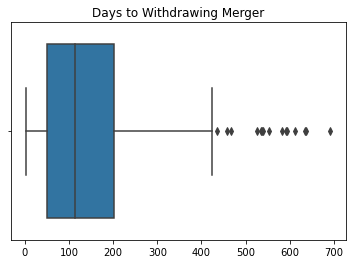

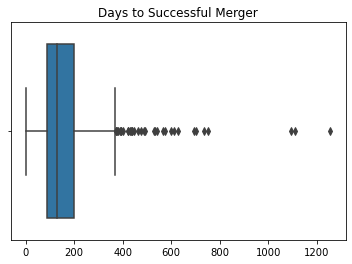

In [12]:
failure_df = df[df["Success"]==0]
withdrawn_dates_df = failure_df[['Date Announced', 'Date Withdrawn']].dropna()
delta_withdrawal = withdrawn_dates_df["Date Withdrawn"] - withdrawn_dates_df["Date Announced"]
days_to_withdrawal = [delta.days for delta in delta_withdrawal]
plt.figure()
sns.boxplot(x=days_to_withdrawal).set(title='Days to Withdrawing Merger')

success_df = df[df["Success"]==1]
completed_dates_df = success_df[['Date Announced', 'Date Effective']].dropna()
delta_completion = completed_dates_df['Date Effective'] - completed_dates_df["Date Announced"]
days_to_completion = [delta.days for delta in delta_completion]
plt.figure()
sns.boxplot(x=days_to_completion).set(title='Days to Successful Merger')

print("Median days to withdrawing merger: " + str(round(np.median(days_to_withdrawal))))
print("For merger withdrawals, 180 days is at percentile: " + str((np.array(days_to_withdrawal) < 180).mean()))
print("Median days to completing merger: " + str(round(np.median(days_to_completion))))
print("For merger success cases, 180 days is at percentile: " + str((np.array(days_to_completion) < 180).mean()))

In [13]:
user_cannot_fill_colname_list = ['Acquiror Closing Price 180 Days After Ann Date ($)', 'Target Closing Price 180 Days After Ann Date ($)','Value Based on Effective Date ($mil)','Value Common at Eff. Date ($mil)','Equity Value at Effective Date ($mil)']

The data is positively skewed. This would affect our choice of loss function, e.g. using focal loss instead of binary cross entropy and our choice of metrics. It would also affect our choice of performance metrics, for e.g. choosing AUC score from ROC curve. We can also try to apply synthetic data creation methods, such as SMOTE, GAN or VAEs

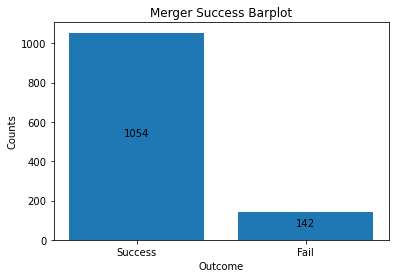

In [14]:
df_success_counts = df["Success"].value_counts().rename_axis('Outcome').reset_index(name='Counts')
df_success_counts["Outcome"] = df_success_counts["Outcome"].replace([1, 0], ["Success", "Fail"])

x, y = df_success_counts["Outcome"], df_success_counts["Counts"]
plt.bar(x, y)
add_labels_inside_chart(x,y)
plt.xlabel("Outcome")
plt.ylabel("Counts")
plt.title("Merger Success Barplot")

plt.show()

# Who are the top acquirors?

In [15]:
success_df.groupby(by="Acquiror Name").size().sort_values(ascending=False).reset_index(name='count')[:10]

,Acquiror Name,count
0,Investor Group,25
1,Apollo Global Management LLC,8
2,"FNB Corp,Pittsburgh,Pennsylvan",6
3,Brookfield Asset Managemnt Inc,6
4,Liberty Interactive Corp,5
5,Microchip Technology Inc,5
6,"WesBanco Inc,Wheeling,WV",5
7,Energy Transfer Partners LP,4
8,OceanFirst Financial Corp,4
9,TPG Capital LP,4


In [16]:
failure_df.groupby(by="Acquiror Name").size().sort_values(ascending=False).reset_index(name='count')[:10]

,Acquiror Name,count
0,Investor Group,7
1,Iliad SA,2
2,Comcast Corp,2
3,Vintage Capital Management LLC,2
4,Mitel Networks Corp,2
5,Quad/Graphics Inc,2
6,Orchestra Premaman SA,1
7,Origin Technologies Corp LLC,1
8,OCI NV,1
9,Mill Road Capital Mgmt LLC,1


# Is Success or Failure related to time?

As the model would be used to predict future mergers, the year of the announcement should not be very important to the outcome so it should be dropped. But, how about month? From the stacked barplot, the number of successes and failures remain relatively constant through the months. A check with the chi squared test revealed that month is independent from success of merger as well.

Checking independence by Chi Squared Test: 
Independent (fail to reject H0)


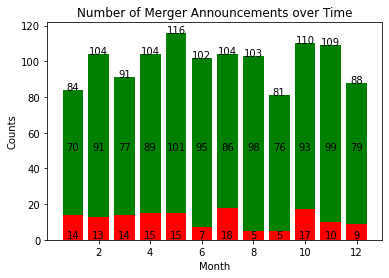

In [17]:
failure_by_month_df = df[df["Success"]==0]["Date Announced"].dt.month.value_counts().rename_axis('Month').reset_index(name='Counts').sort_values(by=["Month"])
success_by_month_df = df[df["Success"]==1]["Date Announced"].dt.month.value_counts().rename_axis('Month').reset_index(name='Counts').sort_values(by=["Month"])
df_month = df["Date Announced"].dt.month.value_counts().rename_axis('Month').reset_index(name='Counts').sort_values(by=["Month"])
x, y, y_fail, y_success = list(failure_by_month_df["Month"]),list(df_month["Counts"]), list(failure_by_month_df["Counts"]), list(success_by_month_df["Counts"])

fig, ax = plt.subplots()
plt.bar(x, y_fail, color='r')
plt.bar(x, y_success,  bottom=y_fail, color='g')

# label
for i in range(len(x)):
    plt.text(i+1, y[i], y[i], ha = 'center')
    plt.text(i+1, 1, y_fail[i], ha = 'center')
    plt.text(i+1, 50, y_success[i], ha = 'center')
    
plt.xlabel("Month")
plt.ylabel("Counts")
plt.title("Number of Merger Announcements over Time")

month_success_table = np.array([list(failure_by_month_df["Counts"]), list(success_by_month_df["Counts"])]).T
conductChiSquaredTest(month_success_table)

# Is Success or Failure dependent on Industry?

There are industries with low merger count that have 100% success rate. These rows could be dropped.

In [18]:
success_by_industry = pd.pivot_table(df, values="Success", index="Target Industry Sector", aggfunc={"Success": [np.sum, np.mean]})
industry_compare = pd.merge(success_by_industry, df.groupby("Target Industry Sector").size().rename("Sample Size"), how="left", on="Target Industry Sector")
industry_compare.columns = ["Mean Success", "Number of Success", "Sample Size"]
industry_compare["Number of Failures"] = industry_compare["Sample Size"] - industry_compare["Number of Success"]
industry_compare["Percentage Success"] = industry_compare["Number of Success"]/industry_compare["Sample Size"] 
industry_compare["Percentage Failure"] = industry_compare["Number of Failures"]/industry_compare["Sample Size"] 
industry_compare[industry_compare["Percentage Success"] == 1]

,Mean Success,Number of Success,Sample Size,Number of Failures,Percentage Success,Percentage Failure
Target Industry Sector,,,,,,
"Agriculture, Forestry, and Fishing",1.0,4,4,0,1.0,0.0
Air Transportation and Shipping,1.0,2,2,0,1.0,0.0
Amusement and Recreation Services,1.0,12,12,0,1.0,0.0
Construction Firms,1.0,8,8,0,1.0,0.0
Educational Services,1.0,2,2,0,1.0,0.0
Leather and Leather Products,1.0,4,4,0,1.0,0.0
Paper and Allied Products,1.0,8,8,0,1.0,0.0
Personal Services,1.0,5,5,0,1.0,0.0
Repair Services,1.0,3,3,0,1.0,0.0


In [19]:
industries_to_drop = list(industry_compare[industry_compare["Percentage Success"] == 1].index)

# Evaluating the Time series data

We can see a difference between the percentage change for merger success and merger failed cases

In [20]:
def getPercentageChangeForThreeYears(col_name_list, df):
    filtered_df = df[col_name_list]
    num_rows = filtered_df.shape[0]
    filtered_df = filtered_df.dropna()
    filtered_num_rows = filtered_df.shape[0]
    percentage_rows_deleted  = round((num_rows-filtered_num_rows) / num_rows * 100, 2)
    print(f"Percentage of rows deleted is {percentage_rows_deleted}%")
    first_second_change = df[col_name_list[1]] - df[col_name_list[0]]/df[col_name_list[0]] * 100
    second_third_change = df[col_name_list[2]] - df[col_name_list[1]]/df[col_name_list[1]] * 100
    print(f"Mean change is from {round(np.mean(first_second_change),2)}% for first to second year to {round(np.mean(second_third_change),2)}% for second to third year")

col_name_grid =    [('Target Book Value/sh', ['Target Book Value/sh One Year Prior','Target Book Value/sh Two Years Prior','Target Book Value/sh Three Years Prior']),
    ('Target Captial Expend.',['Target Capital Expend. One Year Prior ($ mil)', 'Target Capital Expend. Two Years Prior ($ mil)','Target Capital Expend. Three Years Prior ($ mil)']),
    ( 'Target Cash & Mktbl', ['Target Cash & Mktbl. Securities One Year Prior ($ mil)', 'Target Cash & Mktbl. Securities Two Years Prior ($ mil)','Target Cash & Mktbl. Securities Three Years Prior ($ mil)']),
    ('Host Curr. Target Long Term Debt', ['Host Curr. Target Long Term Debt One Year Prior (mil)', 'Host Curr. Target Long Term Debt Two Years Prior (mil)','Host Curr. Target Long Term Debt Three Years Prior (mil)']),
    ('Target Long-Term Liab.', ['Target Long- Term Liab. 1-Year Prior ($ mil)', 'Target Long- Term Liab. 2-Years Prior ($ mil)','Target Long- Term Liab. 3-Years Prior ($ mil)']),
     ('Target Net Cash Fr. Investing', ['Target Net Cash Fr. Investing One Year Prior', 'Target Net Cash Fr. Investing Two Years Prior', 'Target Net Cash Fr. Investing Three Years Prior']),
     ('Target Net Cash fr. Financing', ['Target Net Cash fr. Financing One Year Prior','Target Net Cash fr. Financing Two Years Prior','Target Net Cash fr. Financing Three Years Prior']),
     ('Target Straight Debt', [  'Target Straight Debt One Year Prior ($ mil)','Target Straight Debt Two Years Prior ($ mil)','Target Straight Debt Three Years Prior ($ mil)'])]

for tup in col_name_grid:
    general_col_name = tup[0]
    col_name_list = tup[1]
    print(general_col_name)
    print(f"\nTrend in percentage change for {general_col_name} for Merger success cases")
    getPercentageChangeForThreeYears(col_name_list, success_df)
    print(f"\nTrend in percentage change for {general_col_name} for Merger failure cases")
    getPercentageChangeForThreeYears(col_name_list, failure_df)
    print("\n")

Target Book Value/sh

Trend in percentage change for Target Book Value/sh for Merger success cases
Percentage of rows deleted is 0.85%
Mean change is from -87.27% for first to second year to -90.8% for second to third year

Trend in percentage change for Target Book Value/sh for Merger failure cases
Percentage of rows deleted is 1.41%
Mean change is from -86.01% for first to second year to -87.4% for second to third year


Target Captial Expend.

Trend in percentage change for Target Captial Expend. for Merger success cases
Percentage of rows deleted is 3.23%
Mean change is from 54.17% for first to second year to 47.82% for second to third year

Trend in percentage change for Target Captial Expend. for Merger failure cases
Percentage of rows deleted is 2.11%
Mean change is from 209.11% for first to second year to 202.07% for second to third year


Target Cash & Mktbl

Trend in percentage change for Target Cash & Mktbl for Merger success cases
Percentage of rows deleted is 20.59%
Mean c

In [21]:
def getPercentageChangeForDay1ToDay180AfterAnnouncement(col_name_list, df):
    filtered_df = df[col_name_list]
    num_rows = filtered_df.shape[0]
    filtered_df = filtered_df.dropna()
    filtered_num_rows = filtered_df.shape[0]
    percentage_rows_deleted  = round((num_rows-filtered_num_rows) / num_rows * 100, 2)
    print(f"Percentage of rows deleted is {percentage_rows_deleted}%")
    day1_to_day60_change = df[col_name_list[1]] - df[col_name_list[0]]/df[col_name_list[0]] * 100
    day60_to_day90_change = df[col_name_list[2]] - df[col_name_list[1]]/df[col_name_list[1]] * 100
    day90_to_day180_change = df[col_name_list[3]] - df[col_name_list[1]]/df[col_name_list[2]] * 100
    print(f"Mean change is from {round(np.mean(day1_to_day60_change),2)}% for day 1 to day 60 to {round(np.mean(day60_to_day90_change),2)}% for day 60 to day 90 and to {round(np.mean(day90_to_day180_change),2)}% for day 90 to day 180")


col_name_grid = [('Acquiror Closing Price', ['Acquiror Closing Price 1 Day After Ann Date ($)','Acquiror Closing Price 60 Days After Ann Date ($)',
                              'Acquiror Closing Price 90 Days After Ann Date ($)','Acquiror Closing Price 180 Days After Ann Date ($)']),
    ('Target Share Price', ['Target Closing Price 1 Day After Ann Date ($)','Target Closing Price 60 Days After Ann Date ($)', 'Target Closing Price 90 Days After Ann Date ($)', 
                             'Target Closing Price 180 Days After Ann Date ($)'])]
    
for tup in col_name_grid:
    general_col_name = tup[0]
    col_name_list = tup[1]
    print(general_col_name)
    print(f"\nTrend in percentage change for {general_col_name} for Merger success cases")
    getPercentageChangeForDay1ToDay180AfterAnnouncement(col_name_list, success_df)
    print(f"\nTrend in percentage change for {general_col_name} for Merger failure cases")
    getPercentageChangeForDay1ToDay180AfterAnnouncement(col_name_list, failure_df)
    print("\n")

Acquiror Closing Price

Trend in percentage change for Acquiror Closing Price for Merger success cases
Percentage of rows deleted is 30.17%
Mean change is from 948.29% for day 1 to day 60 to 932.01% for day 60 to day 90 and to 925.97% for day 90 to day 180

Trend in percentage change for Acquiror Closing Price for Merger failure cases
Percentage of rows deleted is 35.21%
Mean change is from 202.07% for day 1 to day 60 to 211.68% for day 60 to day 90 and to 198.55% for day 90 to day 180


Target Share Price

Trend in percentage change for Target Share Price for Merger success cases
Percentage of rows deleted is 61.95%
Mean change is from -64.4% for day 1 to day 60 to -63.7% for day 60 to day 90 and to -58.18% for day 90 to day 180

Trend in percentage change for Target Share Price for Merger failure cases
Percentage of rows deleted is 10.56%
Mean change is from -62.32% for day 1 to day 60 to -62.66% for day 60 to day 90 and to -66.07% for day 90 to day 180




## Checking columns with many missing vlaues

In [22]:
# columns with missing values > 50%
percentage_missing_values = df.isnull().sum() / df.shape[0]
cols_to_drop_by_missing_values = list(percentage_missing_values[percentage_missing_values.values > 0.5].index)

## Checking categorical Values for similar columns

In [23]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
non_numeric_cols = list(filter(lambda column: column not in df.select_dtypes(include=numerics).columns, df.columns))
non_numeric_cols 

['Date Announced',
 'Date Effective',
 'Date Withdrawn',
 'Target Name',
 'Target Primary Ticker Symbol',
 'Target Industry Sector',
 'Acquiror Name',
 'Acquiror Primary Ticker Symbol',
 'Acquiror Industry Sector',
 'Poison Pill']

In [24]:
# Checking categorical values
categorical_df = df[non_numeric_cols]
categorical_unique_values = categorical_df.nunique(axis=0) / categorical_df.shape[0] * 100
categorical_unique_values.sort_values()

Poison Pill                        0.167224
Target Industry Sector             4.598662
Acquiror Industry Sector           4.598662
Date Withdrawn                    11.454849
Acquiror Primary Ticker Symbol    52.675585
Date Effective                    64.715719
Date Announced                    74.247492
Acquiror Name                     77.508361
Target Primary Ticker Symbol      93.227425
Target Name                       93.896321
dtype: float64

# Post EDA Cleaning of Data

In [25]:
cleaned_df = df.copy()
repeated_categorical_cols = ['Acquiror Name', 'Target Name'] # value can be captured with Acquiror/Target Primary Ticker Symbol
date_cols = ['Date Announced', 'Date Effective', 'Date Withdrawn'] # the dates of the previous mergers are not relevant to users predicting for future mergers
cols_to_drop = list(set(user_cannot_fill_colname_list + cols_to_drop_by_missing_values + date_cols + repeated_categorical_cols))
cleaned_df = cleaned_df.drop(cols_to_drop, axis=1) # contains cols which require knowledge of merger result
cleaned_df = cleaned_df[[industry not in industries_to_drop for industry in cleaned_df["Target Industry Sector"]]]

# Train Test Split

In [26]:
X = cleaned_df.drop("Success", axis=1)
y = cleaned_df["Success"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Feature Selection

In [27]:
from sklearn.impute import KNNImputer

Chi Squared test can be used to keep the features that are not independent to the success of the merger. Higher p value means that we can drop that column.

In [28]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(X_train.select_dtypes(include=numerics).columns)
categorical_cols = list(filter(lambda column: column not in numeric_cols, X_train.columns))

numerical_X_train = X_train[numeric_cols]
categorical_X_train = X_train[categorical_cols]
processed_numerical_X_train = numerical_X_train.copy()
knn_imputer = KNNImputer(n_neighbors=2)  
processed_numerical_X_train[:] = knn_imputer.fit_transform(numerical_X_train)

<ipython-input-28-25a3f7b292eb>:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  processed_numerical_X_train[:] = knn_imputer.fit_transform(numerical_X_train)


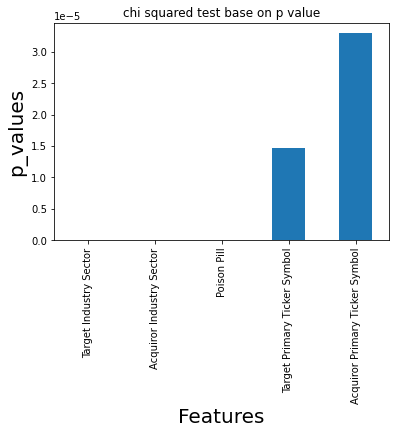

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
processed_categorical_X = categorical_X_train.copy()
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
processed_categorical_X[:] = categorical_imputer.fit_transform(categorical_X_train)
for col in processed_categorical_X.columns:
    processed_categorical_X[col] = le.fit_transform(processed_categorical_X[col].astype(str))


f_score=chi2(processed_categorical_X,y_train)   #returns f score and p value
p_value=pd.Series(f_score[1],index=processed_categorical_X.columns)[:10]
p_value.sort_values(ascending=True,inplace=True)
p_value.plot(kind="bar")
plt.xlabel("Features",fontsize=20)
plt.ylabel("p_values",fontsize=20)
plt.title("chi squared test base on p value")
plt.show()

Further the means and smaller the within variances, better the feature is.Higher score means feature discriminates better between the classes.

In [30]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# generate dataset
org_cols = processed_numerical_X_train.columns
# define feature selection
fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(processed_numerical_X_train, y_train)

col_and_score_list = []
for i in range(len(fs.scores_)):
  col_name = org_cols[i]
  score = fs.scores_[i]
  col_and_score_list.append((col_name, score))

sorted_col_and_score_list_f_classif = sorted(col_and_score_list, key=lambda tup: tup[1], reverse=True)
for tup in sorted_col_and_score_list_f_classif[:10]:
  print('%s: %f' % (tup[0], tup[1]))

Target Net Sales LTM ($mil): 44.127519
Target Cash & Mktbl. Securities Three Years Prior ($ mil): 32.526371
Target EBITDA LTM ($mil): 29.740616
Target Cash & Mktbl. Securities Two Years Prior ($ mil): 28.327003
Target Cash & Mktbl. Securities One Year Prior ($ mil): 27.504849
Pre-tax Income Last Twelve Months ($ Mil): 25.557456
EBIT Last Twelve Months ($ Mil): 23.632919
Target Net Cash fr. Financing Two Years Prior: 21.018990
Net Income Last Twelve Months ($ Mil): 18.671157
Target Total Assets ($mil): 17.688801


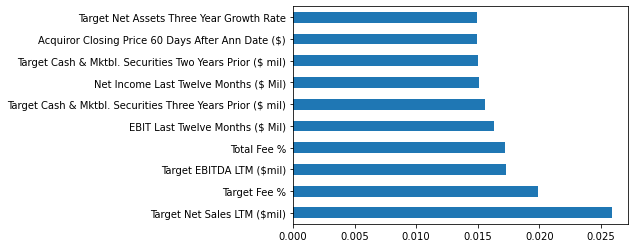

In [31]:
# Feature Selection By Feature Importance
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(processed_numerical_X_train,y_train)
feature_importances = pd.Series(model.feature_importances_, index=processed_numerical_X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

['Target Share Price 1 Day Prior to Announcement ($)',
 'Target Closing Price 90 Days After Ann Date ($)',
 '% sought',
 'Ratio of Deal Value to Sales',
 'Ratio of Enterprise Value to EBIT',
 'EBIT Margin',
 'Total Fee %',
 'Target Fee %',
 'Value / Net Assets',
 'EBITDA ROA',
 'Target Net Sales LTM ($mil)',
 'EBIT Last Twelve Months ($ Mil)',
 'Target Net Assets ($mil)',
 'Target Total Assets ($mil)',
 'Target EBITDA LTM ($mil)',
 'Target Book Value/sh Two Years Prior',
 'Target Capital Expend. Two Years Prior ($ mil)',
 'Target Capital Expend. Three Years Prior ($ mil)',
 'Target Long- Term Liab. 1-Year Prior ($ mil)',
 'Target Long- Term Liab. 2-Years Prior ($ mil)',
 'Target Long- Term Liab. 3-Years Prior ($ mil)',
 'Target Net Cash Fr. Investing Two Years Prior',
 'Target Net Cash fr. Financing One Year Prior',
 'Target Net Cash fr. Financing Two Years Prior',
 'Target Net Cash fr. Financing Three Years Prior']

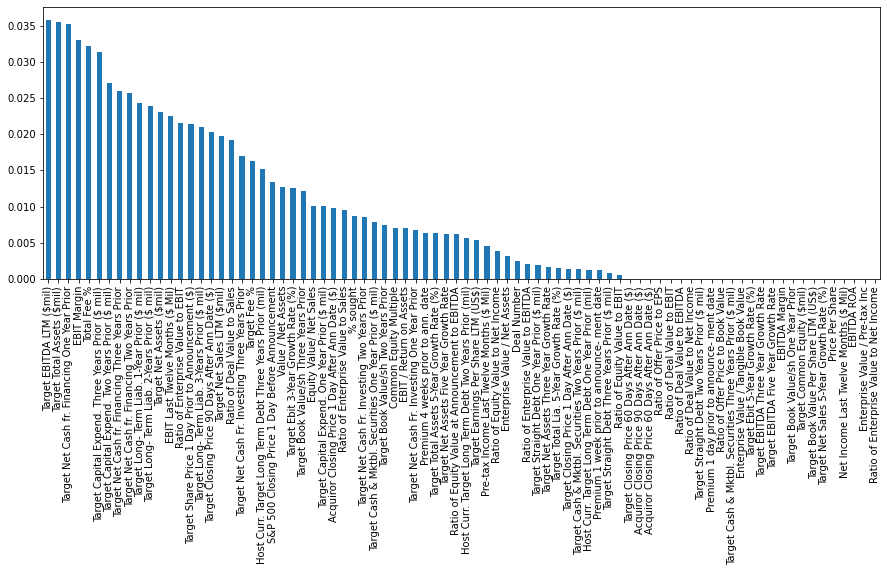

In [32]:
# Feature Selection by Mutual Information
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectPercentile

mutual_info = mutual_info_regression(processed_numerical_X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = processed_numerical_X_train.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

selected_top_columns = SelectPercentile(mutual_info_regression, percentile=30)
selected_top_columns.fit(processed_numerical_X_train, y_train)
selected_top_columns.get_support()
cols_with_most_information = list(processed_numerical_X_train.columns[selected_top_columns.get_support()])
cols_with_most_information

# Baseline Classifier

Done processing the column name lists


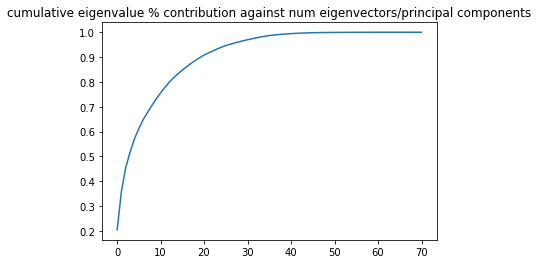

ROC AUC SCORE = 0.5192084942084942, PRECISION SCORE  = 0.8707482993197279, F1 SCORE = 0.925858951175407


,precision,recall,f1-score,support
0,0.400000,0.050000,0.088889,40.000000
1,0.870748,0.988417,0.925859,259.000000
accuracy,0.862876,0.862876,0.862876,0.862876
macro avg,0.635374,0.519208,0.507374,299.000000
weighted avg,0.807772,0.862876,0.813890,299.000000


In [33]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score

cols_df = pd.read_csv("columns_to_select_experiment.csv")
minmax_cols = cols_df[cols_df["kind"] == "ratio"]["column_names"].values # columns that are already in terms of ratios, send direct to minmax/std scaler
scalar_cols = cols_df[cols_df["kind"] == "scalar"]["column_names"].values # columns that are in abs terms
all_cols = cols_df[cols_df["kind"].isin(["ratio","scalar"])]["column_names"].values

print("Done processing the column name lists")

X = df[all_cols]
y = df["Success"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

imputer = SimpleImputer(missing_values=np.nan, strategy="median")
imputer.fit(X_train)

X_train_imputed = pd.DataFrame(imputer.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), index=X_test.index, columns=X_test.columns)

scaler = MinMaxScaler().fit(X_train_imputed)

X_train_norm = pd.DataFrame(scaler.transform(X_train_imputed), index=X_train_imputed.index, columns=X_train_imputed.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test_imputed), index=X_test_imputed.index, columns=X_test_imputed.columns)

num_cols_X_train = X_train.shape[1]
pca = PCA(n_components=num_cols_X_train)
pca.fit(X_train_norm)

plt.plot(pca.explained_variance_ratio_.cumsum(), "-")
plt.title("cumulative eigenvalue % contribution against num eigenvectors/principal components")
plt.show()

optimal_num_of_col = 30
pca = PCA(n_components=optimal_num_of_col)
pca.fit(X_train_norm)
X_train_pca = pd.DataFrame(pca.transform(X_train_norm), index=X_train_norm.index)
X_test_pca = pd.DataFrame(pca.transform(X_test_norm), index=X_test_norm.index)

clf = GradientBoostingClassifier()
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)
print(f"ROC AUC SCORE = {roc_auc_score(y_test, y_pred)}, PRECISION SCORE  = {precision_score(y_test, y_pred)}, F1 SCORE = {f1_score(y_test, y_pred)}")

pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

# Data Cleaning after Feature Selection

In [34]:
X = cleaned_df.drop("Success", axis=1)
y = cleaned_df["Success"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

feature_selected_cleaned_X_train = X_train.copy()

cols_to_keep_set = set()
# chi square
for col in ["Acquiror Primary Ticker Symbol", "Target Primary Ticker Symbol"]:
    cols_to_keep_set.add(col) # col with highest p value

# f_classif
for col in  [tup[0] for tup in sorted_col_and_score_list_f_classif[:10]]:
    cols_to_keep_set.add(col)
    
#feature importance
for col in list(feature_importances.nlargest(10).index):
    cols_to_keep_set.add(col)

#mutual information
for col in cols_with_most_information:
    cols_to_keep_set.add(col)
    
feature_selected_cleaned_X_train = feature_selected_cleaned_X_train[list(cols_to_keep_set)]

print("Columns dropped: " + str(X_train.shape[1] - feature_selected_cleaned_X_train.shape[1]))
print("Number of columns left: " + str(feature_selected_cleaned_X_train.shape[1]))

Columns dropped: 53
Number of columns left: 34


## Comparing between different Scikit models

https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/ (explore using select perccentile to put feature selection into the pipeline)

In [35]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(feature_selected_cleaned_X_train.select_dtypes(include=numerics).columns)
categorical_cols = list(filter(lambda column: column not in numeric_cols, feature_selected_cleaned_X_train.columns))

for col in categorical_cols:
    feature_selected_cleaned_X_train[col] = feature_selected_cleaned_X_train[col].astype(str)

numeric_transformer = Pipeline(steps=[
   ('imputer', KNNImputer(n_neighbors=2)), ('num', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
   ('imputer', SimpleImputer(strategy='most_frequent')), ('cat', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(transformers=[('numeric', numeric_transformer, numeric_cols), ('categorical', categorical_transformer, categorical_cols)])


In [36]:
from sklearn.ensemble import BaggingClassifier

####################
#PREPRARING MODELS#
###################
models = []
models.append(("LR",BaggingClassifier(base_estimator=LogisticRegression())))
models.append(("GB",  BaggingClassifier(base_estimator=GradientBoostingClassifier())))
models.append(("NB", BaggingClassifier(base_estimator=GaussianNB())))
models.append(("Decision Tree", BaggingClassifier(base_estimator=DecisionTreeClassifier())))
              
#################
#TRAINING MODELS#
#################

print("With feature selection")
for name,model in models:
    print(name)
    pipeline = Pipeline(steps=[("preprocessing", preprocessor),("model", model)])
    pipeline.fit(feature_selected_cleaned_X_train,y_train)
    yPred = pipeline.predict(X_test)
    print(roc_auc_score(y_test, yPred), precision_score(y_test, yPred), f1_score(y_test, yPred))

 

With feature selection
LR
0.5058072009291522 0.8876712328767123 0.9350649350649352
GB
0.5073315911730546 0.8879781420765027 0.9365994236311238
NB
0.537746806039489 0.9333333333333333 0.288659793814433
Decision Tree
0.4890389082462253 0.884180790960452 0.9178885630498534


In [37]:
from sklearn import set_config

set_config(display='diagram')
display(pipeline)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=2)),
                                                                  ('num',
                                                                   MinMaxScaler())]),
                                                  ['Target EBITDA LTM ($mil)',
                                                   'Target Long- Term Liab. '
                                                   '2-Years Prior ($ mil)',
                                                   'Target Capital Expend. Two '
                                                   'Years Prior ($ mil)',
                                                   'Acquiror Closing Price 60 '
                                                   'Days After Ann Date ($)',
                                                   'Target Share Price 1 Day '
                                                   'Prior to Announc...
                                                   'Target Net Sales LTM '
                                                   '($mil)',
                                                   'Target Net Cash fr. '
                                                   'Financing Two Years Prior', ...]),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Target Primary Ticker '
                                                   'Symbol',
                                                   'Acquiror Primary Ticker '
                                                   'Symbol'])])),
                ('model',
                 BaggingClassifier(base_estimator=DecisionTreeClassifier()))])

In [ ]:
import tensorflow as tf

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(lr=0.03),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

history = model.fit(feature_selected_cleaned_X_train, y_train, epochs=100)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
plt.plot(
    np.arange(1, 101), 
    history.history['loss'], label='Loss'
)
plt.plot(
    np.arange(1, 101), 
    history.history['accuracy'], label='Accuracy'
)
plt.plot(
    np.arange(1, 101), 
    history.history['precision'], label='Precision'
)
plt.plot(
    np.arange(1, 101), 
    history.history['recall'], label='Recall'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();